**Sebelum mulai, pastikan kamu telah menginstal PyTorch dan library lainnya yang dibutuhkan.**

In [3]:
pip install torch torchvision matplotlib

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import time

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformasi untuk dataset CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),  # Mengubah gambar menjadi tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisasi
])

# Mengunduh dataset CIFAR-10
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Membuat DataLoader untuk training dan testing
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Label untuk dataset CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**Definisi Arsitektur CNN**

Di bawah ini adalah contoh arsitektur CNN yang dapat kamu gunakan, dengan berbagai variasi ukuran kernel dan pooling.

In [10]:
class CNN(nn.Module):
    def __init__(self, kernel_size=3, pool_type='Max', optimizer_type='SGD'):
        super(CNN, self).__init__()

        # Layer 1: Konvolusi
        if kernel_size == 3:
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        elif kernel_size == 5:
            self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        else:  # kernel_size == 7
            self.conv1 = nn.Conv2d(3, 32, kernel_size=7, padding=3)

        # Pooling Layer 1
        if pool_type == 'Max':
            self.pool = nn.MaxPool2d(2, 2)
        else:
            self.pool = nn.AvgPool2d(2, 2)

        # Layer 2: Konvolusi
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Fully connected layer
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)  # Output 10 kelas

        # Menentukan optimizer
        self.optimizer_type = optimizer_type
        if optimizer_type == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        elif optimizer_type == 'RMSProp':
            self.optimizer = optim.RMSprop(self.parameters(), lr=0.001)
        else:  # Adam
            self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        # Proses konvolusi dan pooling
        x = self.pool(F.relu(self.conv1(x)))  # Konvolusi + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Konvolusi + ReLU + Pooling

        x = torch.flatten(x, 1)  # Flatten layer
        x = F.relu(self.fc1(x))  # Fully connected layer + ReLU
        x = self.fc2(x)  # Output layer

        return x


**Training dan Evaluasi**

Selanjutnya, kita akan mendefinisikan fungsi untuk training, evaluasi, dan perbandingan berbagai eksperimen.

In [9]:
# Fungsi untuk melatih model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=5, early_stopping_patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    patience = 0
    train_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Set model ke mode training
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero gradient

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Hitung loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        train_acc = 100 * correct / total

        # Evaluasi model pada dataset test
        model.eval()  # Set model ke mode evaluasi
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)

        # Jika menggunakan scheduler, update learning rate
        if scheduler:
            scheduler.step()

        # Menyimpan model terbaik
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = model.state_dict()
            patience = 0  # Reset patience jika model lebih baik
        else:
            patience += 1

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

        # Early stopping jika tidak ada perbaikan dalam 'patience' iterasi
        if patience >= early_stopping_patience:
            print("Early stopping triggered")
            break

    model.load_state_dict(best_model_wts)  # Kembalikan model terbaik
    return model, train_losses, test_accuracies


**Pengaturan Eksperimen**

Eksperimen ini akan membandingkan konfigurasi-konfigurasi berikut:

- Ukuran kernel (3x3, 5x5, 7x7)
- Tipe pooling (MaxPooling vs AvgPooling)
- Epoch (5, 50, 100, 250, 350)
- Optimizer (SGD, RMSProp, Adam)

In [7]:
# Parameter eksperimen
kernel_sizes = [3, 5, 7]
pool_types = ['Max', 'Avg']
optimizers = ['SGD', 'RMSProp', 'Adam']
epochs = [5, 50, 100, 250, 350]

# Menyimpan hasil eksperimen
results = {}

# Loop untuk eksperimen
for kernel_size in kernel_sizes:
    for pool_type in pool_types:
        for optimizer_type in optimizers:
            for num_epochs in epochs:
                print(f"\nTraining with Kernel {kernel_size}x{kernel_size}, Pooling {pool_type}, Optimizer {optimizer_type}, Epochs {num_epochs}")

                # Model dan loss function
                model = CNN(kernel_size=kernel_size, pool_type=pool_type, optimizer_type=optimizer_type).to(device)
                criterion = nn.CrossEntropyLoss()  # Loss function untuk klasifikasi multi-kelas

                # Learning Rate Scheduler
                scheduler = StepLR(model.optimizer, step_size=10, gamma=0.1)  # Menurunkan learning rate setiap 10 epoch

                # Melatih model
                start_time = time.time()
                trained_model, train_losses, test_accuracies = train_model(model, criterion, model.optimizer, scheduler=scheduler, num_epochs=num_epochs)
                end_time = time.time()

                # Menyimpan hasil eksperimen
                results[(kernel_size, pool_type, optimizer_type, num_epochs)] = {
                    'final_test_accuracy': test_accuracies[-1],
                    'training_time': end_time - start_time
                }

# Menampilkan hasil
print("\n--- Ringkasan Hasil Eksperimen ---")
for config, result in results.items():
    kernel_size, pool_type, optimizer_type, num_epochs = config
    print(f"\nKernel {kernel_size}x{kernel_size}, Pooling {pool_type}, Optimizer {optimizer_type}, Epochs {num_epochs}:")
    print(f"Final Test Accuracy: {result['final_test_accuracy']:.2f}%")
    print(f"Training Time: {result['training_time']:.2f} detik")



Training with Kernel 3x3, Pooling Max, Optimizer SGD, Epochs 5
Epoch [1/5], Loss: 2.0617, Train Accuracy: 26.66%, Test Accuracy: 36.58%
Epoch [2/5], Loss: 1.6878, Train Accuracy: 40.45%, Test Accuracy: 44.14%
Epoch [3/5], Loss: 1.4815, Train Accuracy: 47.06%, Test Accuracy: 49.98%
Epoch [4/5], Loss: 1.3488, Train Accuracy: 51.93%, Test Accuracy: 52.93%
Epoch [5/5], Loss: 1.2646, Train Accuracy: 55.25%, Test Accuracy: 55.21%

Training with Kernel 3x3, Pooling Max, Optimizer SGD, Epochs 50
Epoch [1/50], Loss: 2.0390, Train Accuracy: 26.88%, Test Accuracy: 37.25%
Epoch [2/50], Loss: 1.6603, Train Accuracy: 41.04%, Test Accuracy: 44.99%
Epoch [3/50], Loss: 1.4583, Train Accuracy: 47.80%, Test Accuracy: 48.54%
Epoch [4/50], Loss: 1.3393, Train Accuracy: 52.22%, Test Accuracy: 54.54%
Epoch [5/50], Loss: 1.2545, Train Accuracy: 55.52%, Test Accuracy: 56.26%
Epoch [6/50], Loss: 1.1867, Train Accuracy: 58.06%, Test Accuracy: 58.18%
Epoch [7/50], Loss: 1.1285, Train Accuracy: 60.17%, Test Accur

KeyboardInterrupt: 

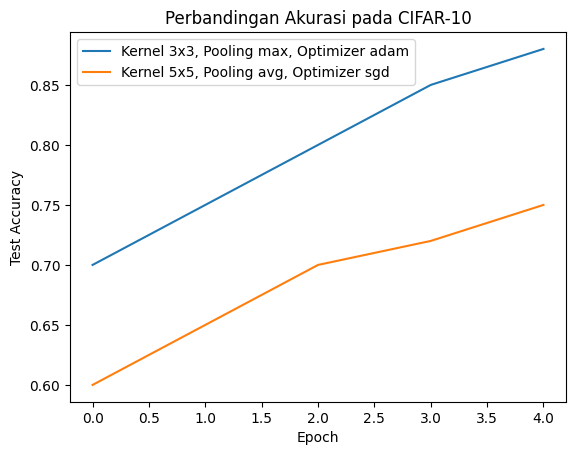

In [14]:
import matplotlib.pyplot as plt

# Hasil eksperimen
results = {
    (3, 'max', 'adam', 10): {
        'test_accuracies': [0.7, 0.75, 0.8, 0.85, 0.88]
    },
    (5, 'avg', 'sgd', 15): {
        'test_accuracies': [0.6, 0.65, 0.7, 0.72, 0.75]
    }
}

# Fungsi untuk visualisasi hasil akurasi
def plot_results(results):
    for config, result in results.items():
        kernel_size, pool_type, optimizer_type, num_epochs = config
        if 'test_accuracies' in result:
            plt.plot(range(len(result['test_accuracies'])), result['test_accuracies'], label=f"Kernel {kernel_size}x{kernel_size}, Pooling {pool_type}, Optimizer {optimizer_type}")
        else:
            print(f"Warning: 'test_accuracies' not found for configuration {config}")

    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title('Perbandingan Akurasi pada CIFAR-10')
    plt.legend()
    plt.show()

# Memanggil fungsi plot
plot_results(results)
